

# Compute power and phase locking in source space

Compute time-frequency maps of power and phase locking in  source space using MNE-type source estimation.

In [1]:
# This notebook is based on MNE-Python tutorials and examples, e.g.
# https://mne.tools/stable/auto_examples/time_frequency/source_space_time_frequency.html
# https://mne.tools/stable/auto_examples/time_frequency/source_label_time_frequency.html

# Modified by Olaf Hauk, olaf.hauk@mrc-cbu.cam.ac.uk
# These notebooks complement the online lectures "Introduction to EEG/MEG analysis":
# https://www.youtube.com/playlist?list=PLp67eqWCj2f_DBsCMkIOBpBbLWGAUKtu5

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import mne
from mne import io
from mne.datasets import sample
from mne.minimum_norm import read_inverse_operator, source_induced_power, source_band_induced_power

Set parameters and create epochs:



In [3]:
data_path = sample.data_path()
meg_path = data_path / "MEG" / "sample"
raw_fname = meg_path / "sample_audvis_raw.fif"
fname_inv = meg_path / "sample_audvis-meg-oct-6-meg-inv.fif"
label_names = ["Aud-lh", "Aud-rh"]  # ROIs for left/right auditory cortex
fname_labels = [meg_path / "labels" / f"{ln}.label" for ln in label_names]
subjects_dir = data_path / "subjects"

# note relatively short epoch length, not necessarily recommended for time-frequency analysis
# this is to minimise computation times
tmin, tmax = -0.2, 0.5
event_id = 2  # auditory right

# Setup for reading the raw data
raw = io.read_raw_fif(raw_fname)
events = mne.find_events(raw, stim_channel="STI 014")
inverse_operator = read_inverse_operator(fname_inv)

include = []
raw.info["bads"] += ["MEG 2443", "EEG 053"]  # bads + 2 more

# Picks MEG channels
picks = mne.pick_types(
    raw.info, meg=True, eeg=False, eog=True, stim=False, include=include, exclude="bads"
)
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)

# Load epochs
epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    picks=picks,
    baseline=(None, 0),
    reject=reject,
    preload=True,
)


Opening raw data file /home/cognestic/COGNESTIC/08_EEG_MEG/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
320 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
Reading inverse operator decomposition from /home/cognestic/COGNESTIC/08_EEG_MEG/MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Noise covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    22494

We read labels (aka ROIs) and select one for which we want to run the time-frequency analysis (here: left and right auditory cortex):

In [4]:
labels = [mne.read_label(fl) for fl in fname_labels]  # read the labels (vertices of source space)
label = labels[0]

We check whether our label overlaps with peaks of interest in evoked activity:

In [5]:
method = 'MNE'
stc = mne.minimum_norm.apply_inverse(epochs.average(), inverse_operator, lambda2=1., method=method, pick_ori=None)  # create source estimate
brain = stc.plot(initial_time=0.1, hemi='both', subjects_dir=subjects_dir)
brain.add_label(labels[0], borders=True, color="k")  # add label 1
brain.add_label(labels[1], borders=True, color="k")  # add label 2

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 59
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
Applying inverse operator to "2"...
    Picked 305 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  33.3% variance
    Combining the current components...
[done]
Using pyvistaqt 3d backend.
Using control points [5.04049494e-11 5.89069331e-11 1.94625767e-10]
True


Note that the label is closer to the maximum in the right compared to the left hemisphere. 

We have to specify the usual parameters for our time-frequency analysis via wavelets.

We then combine this with the inverse operator to perform the analysis in source space:

In [6]:
freqs = np.arange(7, 30, 2)  # define frequencies of interest
n_cycles = freqs / 3.0  # different number of cycle per frequency

lambda2 = 10.  # note: lower SNR for single trial level

power, itc = source_induced_power(
    epochs,
    inverse_operator,
    freqs,
    [label],  # list, even though just one label here
    method=method,
    lambda2=lambda2,
    baseline=(-0.2, 0),
    baseline_mode="percent",
    n_cycles=n_cycles,
    n_jobs=None,
)

times = epochs.times

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
Picked 305 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Reducing data rank 99 -> 99
Computing source power ...
Averaging induced power across vertices within labels for 1 label.
Applying baseline correction (mode: percent)


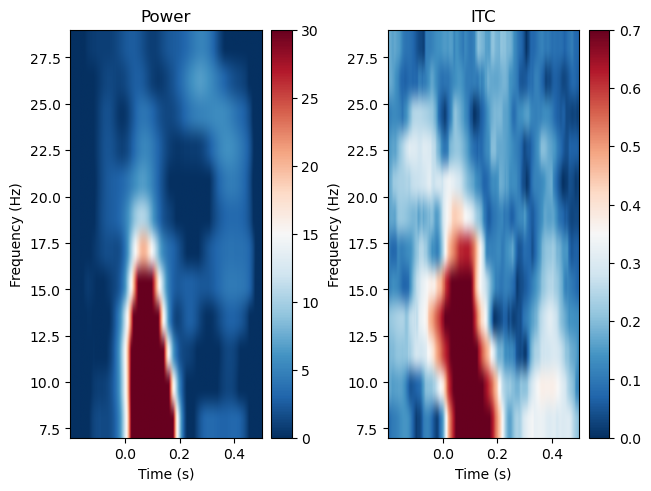

In [7]:
##########################################################################
# View time-frequency plots
fig, axes = plt.subplots(1, 2, layout="constrained")
ax = axes[0]
ax.imshow(
    20 * power[0],  # Decibel; note 'power' is a list (with only one element here)
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    vmin=0.0,
    vmax=30.0,
    cmap="RdBu_r",
)
ax.set(xlabel="Time (s)", ylabel="Frequency (Hz)", title=f"Power")
fig.colorbar(ax.images[0], ax=axes[0])

ax = axes[1]
ax.imshow(
    itc[0],
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    vmin=0,
    vmax=0.7,
    cmap="RdBu_r",
)
ax.set(xlabel="Time (s)", ylabel="Frequency (Hz)", title=f"ITC")
fig.colorbar(ax.images[0], ax=axes[1])

**Exercise:**<br>
- What do these peaks in the time-frequency plot respresent? Do you interpret them as "oscillations"?

We might be tempted to think that we are looking at "oscillations" in these plots. But we may just be looking at a filtered representation of the evoked response, which has peaks within the first ~200ms ("P1", "N2") that roughly correspond to a frequency around 10-20Hz. We can subtract the evoked response from each epoch and see what happens.

Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: EOG 061
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
Picked 305 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Reducing data rank 99 -> 99
Computing source power ...
Outputting power for 33 vertices in label Aud-lh.
Applying baseline correction (mode: percent)


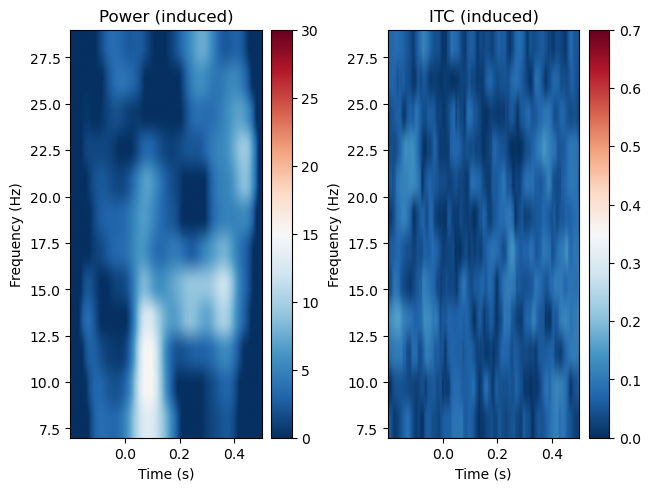

In [8]:
epochs_induced = epochs.copy().subtract_evoked()  # subtract average evoked responses from all epochs

# We replace the epochs with those without the evoked response
# everything else is exactly the same
power, itc = source_induced_power(
    epochs_induced,
    inverse_operator,
    freqs,
    label,
    method=method,
    lambda2=lambda2,
    baseline=(-0.2, 0),
    baseline_mode="percent",
    n_cycles=n_cycles,
    n_jobs=None,
)

##########################################################################
# View time-frequency plots
fig, axes = plt.subplots(1, 2, layout="constrained")
ax = axes[0]
ax.imshow(
    20 * power[0],  # Decibel
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    vmin=0.0,
    vmax=30.0,
    cmap="RdBu_r",
)
ax.set(xlabel="Time (s)", ylabel="Frequency (Hz)", title=f"Power (induced)")
fig.colorbar(ax.images[0], ax=axes[0])

ax = axes[1]
ax.imshow(
    itc[0],
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    vmin=0,
    vmax=0.7,
    cmap="RdBu_r",
)
ax.set(xlabel="Time (s)", ylabel="Frequency (Hz)", title=f"ITC (induced)")
fig.colorbar(ax.images[0], ax=axes[1])

We notice that there is hardly any power or inter-trial phase-locking left. It has mostly been due to the shape of evoked responses.

Note that responses in the frequency domain for which evoked responses have been substracted are also called "induced" (rather than evoked) responses. They are time- but not phase-locked with respect to stimulus onset. Whether evoked and induced responses reflect different types of processing, rather than natural trial-to-trial variations of the same process, is for the experimenter to decide.

We can compute source power for a list of labels, e.g. for the left and right hemisphere separately:



Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 305 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Reducing data rank 180 -> 168
Computing source power ...
Averaging induced power across vertices within labels for 2 labels.
Applying baseline correction (mode: mean)


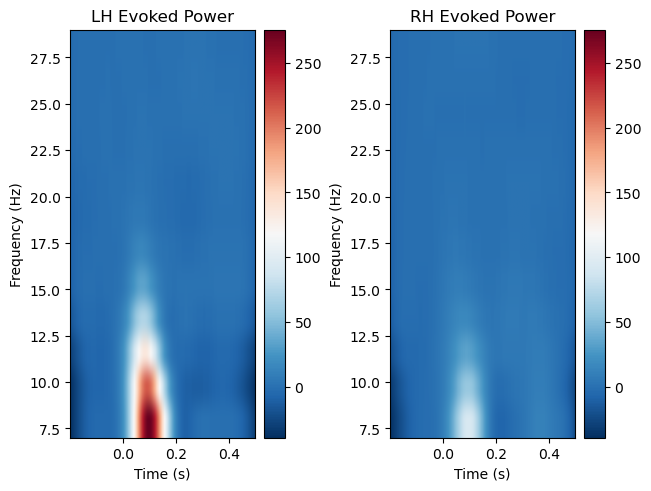

In [9]:
# Get power from multiple labels
multi_label_power = source_induced_power(
    epochs,
    inverse_operator,
    freqs,
    labels, # two labels
    baseline=(-0.1, 0),
    baseline_mode="mean",
    lambda2=lambda2,
    n_cycles=n_cycles,
    n_jobs=None,
    return_plv=False,
)

# visually compare evoked power in left and right auditory regions
fig, axes = plt.subplots(ncols=2, layout="constrained")
for l_idx, l_power in enumerate(multi_label_power):
    ax = axes[l_idx]
    ax.imshow(
        l_power,
        extent=[epochs.times[0], epochs.times[-1], freqs[0], freqs[-1]],
        aspect="auto",
        origin="lower",
        vmin=multi_label_power.min(),
        vmax=multi_label_power.max(),
        cmap="RdBu_r",
    )
    title = f"{labels[l_idx].hemi.upper()} Evoked Power"
    ax.set(xlabel="Time (s)", ylabel="Frequency (Hz)", title=title)
    fig.colorbar(ax.images[0], ax=ax)

**Exercise:**<br>
- It is recommended to use a lower SNR (e.g. 'snr=1' for regularisation of single-trial analysis compared to average evoked responses ('snr=3'). Try different SNRs and check how much it matters.

## Time courses of power in frequency bands

Often we are interested in power time courses in pre-defined frequency bands. Be patient...

In [10]:
# Compute a source estimate per frequency band
bands = dict(alpha=[9, 11], beta=[18, 22])
baseline = (-.1, 0)  # note: we are not using the full baseline
stcs = source_band_induced_power(
    epochs, inverse_operator, bands, method=method, lambda2=lambda2, n_cycles=2, baseline=(-.2, 0.), baseline_mode='percent', use_fft=False, n_jobs=None
)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
Picked 305 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Reducing data rank 305 -> 302
Computing source power ...
[done]
[done]


Then just plot the time courses per frequency band, here averaged across all vertices:

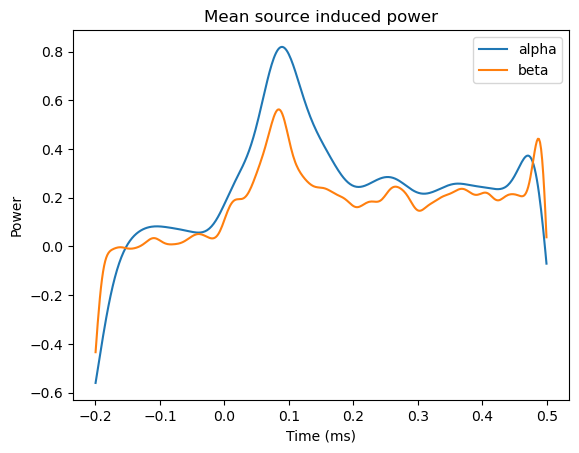

In [11]:
for band in bands:
    plt.plot(stcs[band].times, stcs[band].data.mean(axis=0), label=band)
plt.xlabel("Time (ms)")
plt.ylabel("Power")
plt.legend()
plt.title("Mean source induced power")
plt.show()

**Exercise:**<br>
* Can you meaningfully interpert the differences in power between Alpha and Beta bands? If not, then what can we do about it?
* What is happening at the edges of the epoch? What does this mean for baseline correction?
* Do you think Alpha and Beta activities reflect different processes?

The previous plot represented the averaged power across all vertices. We can also get time courses per label:

In [12]:
label_ts = {}
for band in bands:
    label_ts[band] = stcs[band].extract_label_time_course(labels, inverse_operator['src'], mode='mean')

Extracting time courses for 2 labels (mode: mean)
Extracting time courses for 2 labels (mode: mean)


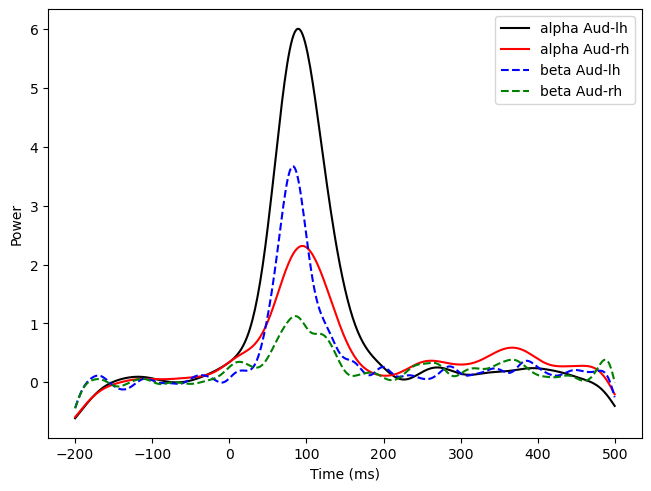

In [13]:
fig, axes = plt.subplots(1, layout="constrained")
times = stcs['alpha'].times
colours = {'alpha': ['k', 'r'], 'beta': ['b--', 'g--']}
for band in bands:
    axes.plot(1e3 * times, label_ts[band][0, :], colours[band][0], label='%s %s' % (band, labels[0].name))
    axes.plot(1e3 * times, label_ts[band][1, :].T, colours[band][1], label='%s %s' % (band, labels[1].name))
    axes.set(xlabel="Time (ms)", ylabel="Power")
    axes.legend()

## Source distributions in frequency bands
Ultimately, we want to look at the source distributions. Since the power time courses are already in STC objects, this is nothing new:

In [14]:
for band in bands:
    stc = stcs[band]
    maxval = stc.data.max()  # for colour scale
    brain = stc.plot(initial_time=0.1, hemi='both', clim={'kind': 'value', 'lims': [0, maxval/2., maxval]}, subjects_dir=subjects_dir)
    brain.add_text(0.1, 0.9, band, "title", font_size=16)

True
True


**Exercise:**<br>
* Do you think alpha and beta band activities are generated by different sources?